In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## WHO - global influenza occurences
The WHO reports Influenza occurences for all around the world on a weekly basis. It is expected that due to spreading patterns of influenza waves throughout the world, influenza waves different countries can be used as an indicator for the prediction of influenza waves for Germany. The data for the **Influenza transmission zone** South West Europe is analysed below 

Note: The influenza transmission zones join geographically related countries or territories to larger areas that have similar influenza transmission patterns so that an overview can be given. www.who.int/csr/.../swineflu/Influenza_Transmission_Zones.pdf


In [41]:
df_who_global = pd.read_csv('FluNetInteractiveReport.csv',skiprows=3,parse_dates=['SDATE','EDATE']).fillna(value = 0)
df_who_global.head(5)


,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,...,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE,INF_A+INF_B
0,Albania,European Region of WHO,South West Europe,2000,1,2000-01-03,2000-01-09,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0.0,Regional Outbreak,0
1,Albania,European Region of WHO,South West Europe,2000,26,2000-06-26,2000-07-02,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0.0,No Report,0
2,Albania,European Region of WHO,South West Europe,2001,4,2001-01-22,2001-01-28,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0.0,Sporadic,0
3,Albania,European Region of WHO,South West Europe,2001,8,2001-02-19,2001-02-25,0.0,0.0,2.0,...,0.0,2,0.0,0.0,0.0,0,2,0.0,Sporadic,2
4,Albania,European Region of WHO,South West Europe,2002,11,2002-03-11,2002-03-17,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0,0.0,No Activity,0


['Country', 'WHOREGION', 'FLUREGION', 'Year', 'Week', 'SDATE', 'EDATE', 'SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB', 'AH1', 'AH1N12009', 'AH3', 'AH5', 'ANOTSUBTYPED', 'INF_A', 'BYAMAGATA', 'BVICTORIA', 'BNOTDETERMINED', 'INF_B', 'ALL_INF', 'ALL_INF2', 'TITLE', 'INF_A+INF_B']


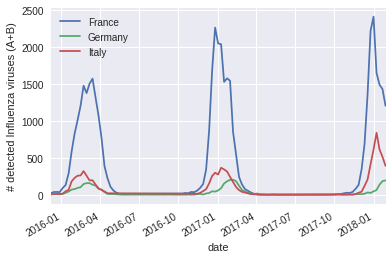

In [58]:
print(list(df_who_global))

df_2years_G_F_I = df_who_global.loc[df_who_global['Country'].isin(['France','Italy','Germany'])&(df_who_global['SDATE']>='2015-12-01')]

df_2years_G_F_I.set_index('SDATE',inplace=True)
fig = plt.figure()
df_2years_G_F_I.groupby('Country')['ALL_INF'].plot(legend = True)

plt.xlabel('date')
plt.ylabel('# detected Influenza viruses (A+B)')

plt.savefig('InfluenzaDetectionsOverTime_France_Germany_Italy.eps')


## Google trend data

Google trend data is expected to give a good estimator of the current influenza situation in a country. It's quality for medium and long term are questionable. 